# Microkinetic modelling of  multi-electron transfer electrocatalyis
$$\require{mhchem}$$
Author: Joel W. Ager (jwager@lbl.gov), [Group website](http://ager.mse.berkeley.edu), [github](https://github.com/joelager)

Adapts analyses in 
>Koper, M. T. M.; Jansen, A. P. J.; van Santen, R. A.; Lukkien, J. J.; Hilbers, P. A. J. Monte Carlo Simulations of a Simple Model for the Electrocatalytic CO Oxidation on Platinum. [*J. Chem. Phys.* **1998**, 109, 6051–6062](http://aip.scitation.org/doi/10.1063/1.477230).

The paper is one of a very few examples of which I am aware of applying a stochastic analysis to electrochemistry: in it, a mean field model is compared to a lattice Monte Carlo simulation for a model reaction, CO stripping from Pt. In this notebook, the mean field model is coded.  

Koper and co-workers consider the two steps of CO oxidation on Pt: 

$$\ce{H2O + $*$  <-> OH_{ads} + H+ + e-}\tag{1}$$

$$\ce{CO_{ads}   <-> CO2 + H+ + e- + 2$*$}\tag{2}$$

In their analysis, reaction (1) will be considered reversible but reaction (2) will be irreversible (i.e. there will not a be way to repopulate the surface with CO). 

Rate constants are:

$$k_1 = k^0_1 \exp(\alpha_1 e_0 E / k_B T) $$

$$k_{-1} = k^0_{-1} (-(1-\alpha_1) \exp(e_0 E / k_B T) $$

$$k_2 = k^0_2 \exp(\alpha_2 e_0 E / k_B T) $$

where $e_0$ is elementary charge and $E$ is the applied potential. Both transfer coefficients $\alpha$ will be set to 0.5. 

The reaction rates $v_i$ are:

$$v_1 = \Gamma_s k_1 (1-\theta_{OH} - \theta_{CO} ) $$

$$v_{-1} = \Gamma_s k_{-1} \theta_{OH}  $$

$$v_2 = \Gamma_s Z k_2 \theta_{OH}  \theta_{CO}  $$

where $\Gamma_s$ is the density of surface sites (cm<sup>-2</sup>) and $Z$ is the number of nearest neighbor sites, which is 4 on the square lattice used.  Total current density is:

$$ j = e_0 (v_1 - v_{-1} + v_2) $$

The time evolution of the mean field coverages $\theta_{CO}$ and $\theta_{OH}$ are governed by two ODEs:

$$\Gamma_s \frac{d \theta_{OH}}{dt} = v_1-v_{-1} -v_2 $$
$$\Gamma_s \frac{d \theta_{CO}}{dt} = -v_2 $$

## Initialize

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Importing the ODE solver
from scipy.integrate import odeint

# Python script with SI units, cgs conversions, and physical constants
from units import *

In [2]:
# Constants to be used throughout the calcuation
T = 300 * kelvin

alpha1 = 0.5
alpha2 = 0.5

Z = 4.0
Γ_sites = 1.32e15 * cm**-2     # Use \Gamma then tab to make greek letters

## CV scan function
In Fig. 1 of paper, scan goes from 0.1 to 0.5 V and back again.  

In [3]:
# Function to construct a single CV scan
Estart =  0.1 *volt
Efinish = 0.5 *volt
sweep_rate = 50.0 *mV*sec**-1
cycle_time = 2.0 * (Efinish-Estart)/sweep_rate 

# A function to define a single CV sweep
def E_CV(t):
    if t<0:
        E = Estart
    elif (t>0 and t < cycle_time/2.0):
        E = Estart + t*sweep_rate
    elif(t>0  and t > cycle_time/2. and t < cycle_time ):
        E = Efinish - (t - cycle_time/2.0) *sweep_rate
    else:
        E = Estart
    return E        

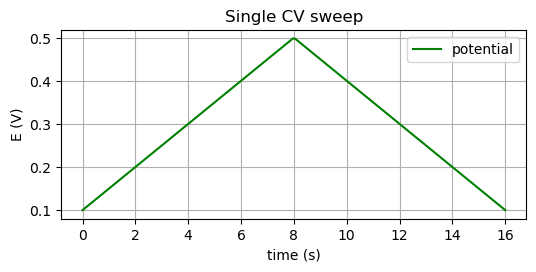

In [4]:
# Checking the CV sweep
t_plot = np.linspace(0,cycle_time,200)

# need to do this because cannot send array to boolean arguments
temp = np.empty(t_plot.size)
for i in range(t_plot.size):
    temp[i] = E_CV(t_plot[i])


plt.figure(figsize=(6,2.5), dpi=100)
plt.plot(t_plot, temp, 'g', label = "potential") 

plt.legend(loc='best')
plt.title('Single CV sweep')
plt.xlabel("time (s)")
plt.ylabel("E (V)")
plt.grid()
plt.show()

## Rate constants

In [9]:
# Default parameters are the "FAST" case from the paper
# These can be overwritten by passing another set of parameters

def k1(E, k1zero=0.02*sec**-1, kminus1zero=1e4*sec**-1, k2zero=0.8234*sec**-1):   
    return k1zero*np.exp( (alpha1*q*E)/(kB*T) )

def kminus1(E, k1zero=0.02*sec**-1, kminus1zero=1e4*sec**-1, k2zero=0.8234*sec**-1):   
    return kminus1zero*np.exp( -((1-alpha1)*q*E)/(kB*T) )

def k2(E, k1zero=0.02*sec**-1, kminus1zero=1e4*sec**-1, k2zero=0.8234*sec**-1):   
    return k2zero*np.exp( (alpha1*q*E)/(kB*T) )


## ODEs and solution

In [6]:
# Sets up the function to be called by odeint
def CV_scan_ODEs(z,t):
    θ_OH= z[0]
    θ_CO = z[1]
    
    dθ_OHdt = k1(E_CV(t),**params)*(1-θ_OH-θ_CO) - \
    kminus1(E_CV(t),**params)*θ_OH - \
    Z*k2(E_CV(t),**params)*θ_OH*θ_CO
    
    dθ_COdt = -Z*k2(E_CV(t),**params)*θ_OH*θ_CO
    dzdt = [dθ_OHdt,dθ_COdt]
    return dzdt

CV scan initiated:
OH coverage  = 0.0
CO Coverage = 0.75


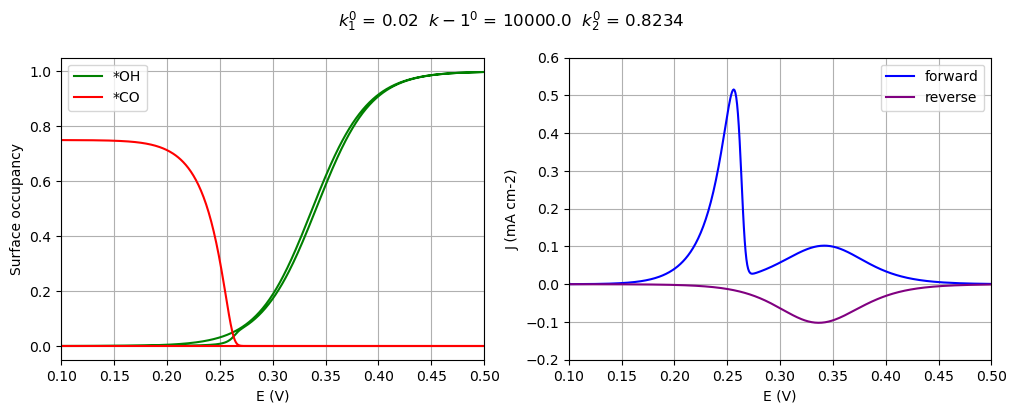

In [19]:
# Choose parameters for the simulations.  More cases can be added
params_FAST = {'k1zero': 0.02,'kminus1zero' : 1e4,'k2zero':0.8234}
params_SLOW = {'k1zero': 0.02,'kminus1zero' : 1e4,'k2zero':0.8234e-5}

# Set the parameter set to be used in current simulation
params=params_FAST          # See cells above for more parameter sets

# Sweep parameters
Estart =  0.1 *volt              # E = 0.3 was largest driving force in Figure 1
Efinish = 0.5 *volt              # Larger driving forces lead to huge currents. 
sweep_rate = 50.0 *mV*sec**-1
cycle_time = 2.0 * (Efinish-Estart)/sweep_rate 

# Intial conditions - nothing will happen if the surface is full
θ_OH_init = 0.00
θ_CO_init = 0.75        # In figure 1 of paper, 0.99, 0.75, and 0.50 are considered

# Boundary conditions for odeint
z0 = [θ_OH_init, θ_CO_init]   

print('CV scan initiated:')
print('OH coverage  =', θ_OH_init)
print('CO Coverage =', θ_CO_init)

# time points for ODE integration
t_CV = np.linspace(0,cycle_time,1000)

# solve ODE
z = odeint(CV_scan_ODEs,z0,t_CV)

θ_OH_sol = z[:,0]
θ_CO_sol = z[:,1]

# Compute the E values for the CV plot 
E_CV_plot = np.empty(t_CV.size)
for i in range(t_CV.size):
    E_CV_plot[i] = E_CV(t_CV[i])

# Compute Current densities for the plot
J_CV_plot = np.empty(t_CV.size)
for i in range(t_CV.size):
    J_CV_plot[i] = (q*Γ_sites)* \
    ( k1(E_CV_plot[i],**params)*(1-θ_OH_sol[i]-θ_CO_sol[i]) - \
    kminus1(E_CV_plot[i],**params)*θ_OH_sol[i] + \
    Z*k2(E_CV_plot[i],**params)*θ_OH_sol[i]*θ_CO_sol[i] )
    
    

# Displayt the results
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,4), dpi=100)

fig.suptitle('$k_1^0$ = {}  $k-1^0$ = {}  $k_2^0$ = {}'.format(params.get('k1zero'),
                        params.get('kminus1zero'),
                        params.get('k2zero')), y =1.0)  
# LH figure
ax1.plot(E_CV_plot, z[:,0], 'g', label = "*OH") 
ax1.plot(E_CV_plot, z[:,1], 'r', label = "*CO")
# can also graph vacancies but makes the figure a bit messy
# ax1.plot(E_CV_plot,1- z[:,1]-z[:,0], 'b', label = "*")
ax1.legend(loc='best')
ax1.grid(True)
ax1.set_xlabel("E (V)")
ax1.set_xlim(Estart,Efinish)
ax1.set_ylabel("Surface occupancy")
ax1.set_ylim(-0.05,1.05)
# RH figure

ax2.plot(np.split(E_CV_plot,2)[0], np.split(J_CV_plot,2)[0]/(mA*cm**-2),'blue', label='forward')
ax2.plot(np.split(E_CV_plot,2)[1], np.split(J_CV_plot,2)[1]/(mA*cm**-2),'purple', label='reverse')
ax2.legend(loc='best')
ax2.grid(True)
ax2.set_xlabel("E (V)")
ax2.set_xlim(Estart,Efinish)
ax2.set_ylabel("J (mA cm-2)")
ax2.set_ylim(-0.2,0.6)

plt.show()

Compare the rate constants. Forward and reverse rates of (1) are the same at ~0.33 V. 

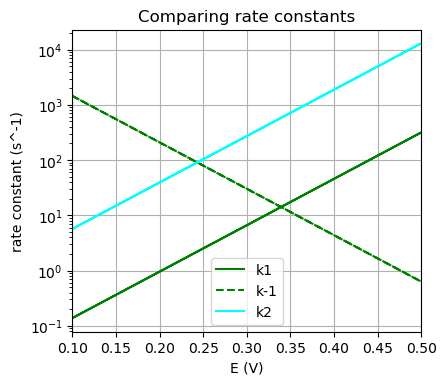

In [8]:
plt.figure(figsize=(4.5,4), dpi=100)
plt.title('Comparing rate constants')

plt.semilogy(E_CV_plot, k1(E_CV_plot,**params),'g', label='k1')
plt.semilogy(E_CV_plot, kminus1(E_CV_plot,**params),'g--', label='k-1')
plt.semilogy(E_CV_plot, k2(E_CV_plot,**params),'cyan' ,label='k2')

plt.legend(loc='best')

plt.xlabel("E (V)")
plt.xlim(0.1,0.5)
plt.ylabel("rate constant (s^-1)")
plt.xlim(0.1,0.5)

plt.grid()
plt.show()